# **Mediapipe To Mixamo**

In [127]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import json
from IPython.display import clear_output
import matplotlib.animation

## **Draw mediapipe function**

In [128]:
def draw_mediapipe(json_object, fidx):
  dot1 = []
  for idx in range(0, 33):
    landmark = json_object['frames'][fidx]["keypoints3D"][idx];
    dot1.append([landmark['x'], landmark['y'], landmark['z']])
    if idx < 10: 
      dot1[idx].append('r')
    elif idx == 24 or idx == 23 or idx == 11 or idx == 12:
      dot1[idx].append('b')
    else:
      dot1[idx].append('g')
    dot1[idx].append('o')
  dot1.append([0.0, 0.0, 0.0, 'b', 'H'])


  fig = plt.figure()  
  ax1 = plt.axes(projection='3d')
  ax1.view_init(elev=10, azim=0)
  ax1.set_xlim(-1.0, 1.0) 
  ax1.set_xlabel("x") 
  ax1.set_ylim(-1.0, 1.0)  
  ax1.set_ylabel("y") 
  ax1.set_zlim(-1.0, 1.0)  
  ax1.set_zlabel("z") 
  color1 = ['r', 'g', 'b', 'k', 'm']
  marker1 = ['o', 'v', '1', 's', 'H']
  i = 0
  for x in dot1:
    ax1.scatter3D(x[0],x[1],x[2], c=x[3],
                marker= x[4], linewidths=1)  
    i += 1
  plt.show()
  return

def draw_all_frame_mediapipe(json_object):
  for fidx in range(0, len(json_object['frames'])):
    clear_output(wait=True)
    draw_mediapipe(json_object, fidx)
  return

## **Mixamo Bone Name** 

In [129]:
g_mixamoName= [
    ['Hips', 0, -1],   #left hip <->right hip
    ['Spine', 1, 0],
        ['Spine1', 2, 1],
            ['Spine2', 3, 2],

                ['Neck', 4, 3], # left_shoulder <-> right_shoulder
                    ['Head', 5, 4],# left_ear <-> right_ear

                ['LeftArm', 6,3, "left_shoulder"],
                    ['LeftForeArm', 7, 6, "left_elbow"],
                        ['LeftHand', 8,7, "left_wrist"],
                            ['LeftHandThumb1', 9, 8, "left_thumb"],
                            ['LeftHandIndex1', 10, 9, "left_index"],
                            ['LeftHandPinky1', 11, 10, "left_pinky"],

                ['RightArm', 12, 3, "right_shoulder"],
                    ['RightForeArm', 13, 12, "right_elbow"],
                        ['RightHand', 14, 13, "right_wrist"],
                            ['RightHandThumb1', 15, 14, "right_thumb"],
                            ['RightHandIndex1', 16, 15, "right_index"],
                            ['RightHandPinky1', 17, 16, "right_pinky"],
    ['LeftLeg', 18, 0, "left_hip"],
        ['LeftUpLeg', 19, 18, "left_knee"],
            ['LeftFoot', 20, 19, "left_ankle"],
                ['LeftToeBase',21, 20, "left_foot_index"],
    ['RightLeg', 22, 0, "right_hip"],
        ['RightUpLeg', 23, 22, "right_knee"],
            ['RightFoot', 24, 23, "right_ankle"],
                ['RightToeBase',25, 24, "right_foot_index"]
]

## **Mediapipe name**

In [130]:
g_mediapipeName = [
 "nose"
,"left_eye_inner"
,"left_eye"
,"left_eye_outer"
,"right_eye_inner"
,"right_eye"
,"right_eye_outer"
,"left_ear"
,"right_ear"
,"mouth_left"
,"mouth_right"
,"left_shoulder"
,"right_shoulder"
,"left_elbow"
,"right_elbow"
,"left_wrist"
,"right_wrist"
,"left_pinky"
,"right_pinky"
,"left_index"
,"right_index"
,"left_thumb"
,"right_thumb"
,"left_hip"
,"right_hip"
,"left_knee"
,"right_knee"
,"left_ankle"
,"right_ankle"
,"left_heel"
,"right_heel"
,"left_foot_index"
,"right_foot_index"]

g_mediapipeName_idx_map = {}
for idx in range(0, len(g_mediapipeName)):
    g_mediapipeName_idx_map[g_mediapipeName[idx]] = idx
g_mediapipeName_idx_map

{'nose': 0,
 'left_eye_inner': 1,
 'left_eye': 2,
 'left_eye_outer': 3,
 'right_eye_inner': 4,
 'right_eye': 5,
 'right_eye_outer': 6,
 'left_ear': 7,
 'right_ear': 8,
 'mouth_left': 9,
 'mouth_right': 10,
 'left_shoulder': 11,
 'right_shoulder': 12,
 'left_elbow': 13,
 'right_elbow': 14,
 'left_wrist': 15,
 'right_wrist': 16,
 'left_pinky': 17,
 'right_pinky': 18,
 'left_index': 19,
 'right_index': 20,
 'left_thumb': 21,
 'right_thumb': 22,
 'left_hip': 23,
 'right_hip': 24,
 'left_knee': 25,
 'right_knee': 26,
 'left_ankle': 27,
 'right_ankle': 28,
 'left_heel': 29,
 'right_heel': 30,
 'left_foot_index': 31,
 'right_foot_index': 32}

In [131]:
g_mixamoName_mediapipeName_map = {}
for idx in range(6, len(g_mixamoName)):
    g_mixamoName_mediapipeName_map[g_mixamoName[idx][0]] = g_mixamoName[idx][3] 
g_mixamoName_mediapipeName_map

{'LeftArm': 'left_shoulder',
 'LeftForeArm': 'left_elbow',
 'LeftHand': 'left_wrist',
 'LeftHandThumb1': 'left_thumb',
 'LeftHandIndex1': 'left_index',
 'LeftHandPinky1': 'left_pinky',
 'RightArm': 'right_shoulder',
 'RightForeArm': 'right_elbow',
 'RightHand': 'right_wrist',
 'RightHandThumb1': 'right_thumb',
 'RightHandIndex1': 'right_index',
 'RightHandPinky1': 'right_pinky',
 'LeftLeg': 'left_hip',
 'LeftUpLeg': 'left_knee',
 'LeftFoot': 'left_ankle',
 'LeftToeBase': 'left_foot_index',
 'RightLeg': 'right_hip',
 'RightUpLeg': 'right_knee',
 'RightFoot': 'right_ankle',
 'RightToeBase': 'right_foot_index'}

## **Mediapipe To Mixamo**

In [132]:
def avg3D(point1, point2):
    return [float(point1[0] + point2[0])/2.0, 
            float(point1[1]+ point2[1])/2.0, 
            float(point1[2]+ point2[2])/2.0, 
            float(point1[3]+ point2[3])/2.0]

def avgMixamoData(mediapipeJsonObject, frameNum, name1, name2):
    left = mediapipeJsonObject[frameNum]["keypoints3D"][g_mediapipeName_idx_map[name1]]
    right = mediapipeJsonObject[frameNum]["keypoints3D"][g_mediapipeName_idx_map[name2]]
    x = float(left['x'] + right['x']) / 2.0
    y = float(left['y'] + right['y']) / 2.0
    z = float(left['z'] + right['z']) / 2.0
    score = (left['score'] + right['score']) / 2.0 
    return [x, y, z, score]

def mediapipeToMixamoHip(resultKeyPointsJsonObject, mediapipeJsonObject, frameNum):
    #left hip <->right hip
    x, y, z, score = avgMixamoData(mediapipeJsonObject, frameNum, "left_hip", "right_hip")
    resultKeyPointsJsonObject["keypoints3D"].append({'x': 0.0, 
                                                     'y': 0.0, 
                                                     'z': 0.0, 
                                                     'score': score, 
                                                     'name': g_mixamoName[0][0], 
                                                     'parent': g_mixamoName[0][2]})
    return
def mediapipeToMixamoSpine(resultKeyPointsJsonObject, mediapipeJsonObject, frameNum):
    # left_hip, right_hip, left_shoulder, right_shoulder
    hip = avgMixamoData(mediapipeJsonObject, frameNum, "left_hip", "right_hip")
    neck = avgMixamoData(mediapipeJsonObject, frameNum, "left_shoulder", "right_shoulder")
    spine2 = avg3D(hip, neck)
    spine1 = avg3D(hip, spine2)
    spine3 = avg3D(spine2, neck)
    spine = [spine1, spine2, spine3]
    for idx in range(0, len(spine)):
        resultKeyPointsJsonObject["keypoints3D"].append({'x': spine[idx][0], 
                                                     'y': spine[idx][1], 
                                                     'z': spine[idx][2], 
                                                     'score': spine[idx][3], 
                                                     'name': g_mixamoName[idx+1][0], 
                                                     'parent': g_mixamoName[idx+1][2]}) 

def mediapipeToMixamoNeck(resultKeyPointsJsonObject, mediapipeJsonObject, frameNum):
    # left_shoulder <-> right_shoulder
    x, y, z, score = avgMixamoData(mediapipeJsonObject, frameNum, "left_shoulder", "right_shoulder")
    resultKeyPointsJsonObject["keypoints3D"].append({'x': x, 
                                                     'y': y, 
                                                     'z': z, 
                                                     'score': score, 
                                                     'name': g_mixamoName[4][0], 
                                                     'parent': g_mixamoName[4][2]})
    return
def mediapipeToMixamoHead(resultKeyPointsJsonObject, mediapipeJsonObject, frameNum):
    # left_shoulder <-> right_shoulder
    x, y, z, score = avgMixamoData(mediapipeJsonObject, frameNum, "left_ear", "right_ear")
    resultKeyPointsJsonObject["keypoints3D"].append({'x': x, 
                                                     'y': y, 
                                                     'z': z, 
                                                     'score': score, 
                                                     'name': g_mixamoName[5][0], 
                                                     'parent': g_mixamoName[5][2]})
    return
def mediapipeToMixamoAll(resultKeyPointsJsonObject, mediapipeJsonObject, frameNum):
    frameKeypoints =  mediapipeJsonObject[frameNum]["keypoints3D"]
    for idx in range(6, len(g_mixamoName)):
        mediapipeName = g_mixamoName_mediapipeName_map[g_mixamoName[idx][0]]
        mediapipeIdx = g_mediapipeName_idx_map[mediapipeName]
        keypoint = frameKeypoints[mediapipeIdx]
        resultKeyPointsJsonObject["keypoints3D"].append({'x': keypoint['x'], 
                                                         'y': keypoint['y'], 
                                                         'z': keypoint['z'], 
                                                         'score': keypoint['score'], 
                                                         'name': g_mixamoName[idx][0], 
                                                         'parent': g_mixamoName[idx][2]})
    return

def mediapipeToMixamo(mediapipeJsonObject):
    jsonObject = {
        "fileName": mediapipeJsonObject['fileName'],
        "duration": mediapipeJsonObject['duration'],
        "ticksPerSecond": mediapipeJsonObject['ticksPerSecond'],
        "frames": []
    }
    for fidx in range(0, len(mediapipeJsonObject['frames'])):
        keypointsJsonObject = {
            "frameNum":  fidx,
            "keypoints3D": []
        }
        mediapipeToMixamoHip(keypointsJsonObject, mediapipeJsonObject['frames'], fidx)
        mediapipeToMixamoSpine(keypointsJsonObject, mediapipeJsonObject['frames'], fidx)
        mediapipeToMixamoNeck(keypointsJsonObject, mediapipeJsonObject['frames'], fidx)
        mediapipeToMixamoHead(keypointsJsonObject, mediapipeJsonObject['frames'], fidx)
        mediapipeToMixamoAll(keypointsJsonObject, mediapipeJsonObject['frames'], fidx)
        jsonObject["frames"].append(keypointsJsonObject)
    return jsonObject

## **Open Mediapipe Json file**

In [133]:
json_object = None
file_name = 'mediapipe_json/mixamo_T_pose.gif.json' 
with open(file_name) as f:
    json_object = json.load(f)

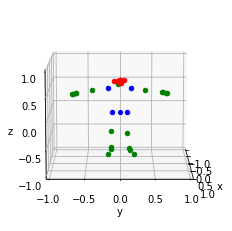

{'x': 0.26960402727127075,
 'y': 0.0006800275878049433,
 'z': 0.6486363410949707,
 'score': 0.999988317489624,
 'name': 'nose'}

In [134]:
draw_mediapipe(json_object, 2)
json_object["frames"][2]["keypoints3D"][0]

## **Write Mixamo Json**

In [135]:
mixamoJsonObject = mediapipeToMixamo(json_object)

In [136]:
with open(file_name+'.json', 'w') as f:
    json_string = json.dump(mixamoJsonObject, f, indent=2)    

## **Draw Mixamo**

In [137]:
def draw_mixamo(json_object, fidx):
  dot1 = []
  for idx in range(0, len(json_object['frames'][fidx]["keypoints3D"])):
    landmark = json_object['frames'][fidx]["keypoints3D"][idx];
    dot1.append([landmark['x'], landmark['y'], landmark['z']])
    if idx <= 5: 
      dot1[idx].append('r')
    elif idx <= 11: # left Arm
      dot1[idx].append('g')
    elif idx <= 17: # right Arm
      dot1[idx].append('b')
    elif idx <= 21: # left leg
      dot1[idx].append('k')
    else:
      dot1[idx].append('m')
    dot1[idx].append('o')
  dot1.append([0.0, 0.0, 0.0, 'b', 's'])


  ax1 = plt.axes(projection='3d')
  ax1.view_init(elev=10, azim=10)
  ax1.set_xlim(-1.0, 1.0) 
  ax1.set_xlabel("x") 
  ax1.set_ylim(-1.0, 1.0)  
  ax1.set_ylabel("y") 
  ax1.set_zlim(-1.0, 1.0)  
  ax1.set_zlabel("z") 
  i = 0
  for x in dot1:
    ax1.scatter3D(x[0],x[1],x[2], c=x[3],
                marker= x[4], linewidths=1)  
    i += 1
  plt.show()
  return

def draw_all_frame_mixamo(json_object):
  fig = plt.figure()  
  for fidx in range(0, len(json_object['frames'])):
    clear_output(wait=True)
    draw_mixamo(json_object, fidx)
  return

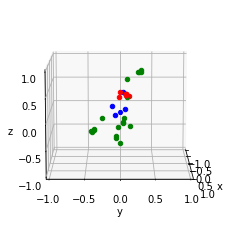

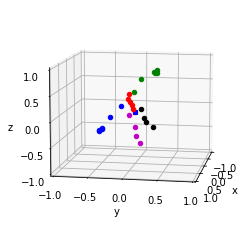

In [138]:
for idx in range(0, len(json_object["frames"]), 3):
    clear_output(wait=True)

    draw_mediapipe(json_object, idx)
    draw_mixamo(mixamoJsonObject, idx)